In [64]:
import numpy as np
import math
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SimulatedBinaryCrossover
from pymoo.operators.mutation.pm import PolynomialMutation

from backend.resident_model import compute_resident
from backend.government_model import compute_government
from backend.developer_model import compute_developer
from backend.input_data import refresh_input


def map_input(x,far=3.5,precision=1):
    bcr = max(round(x[0],precision),0.1)
    # tier = math.ceil(x[1])
    tier = int(far/bcr)
    total = np.sum(x[2:])
    #各部分最小0.1，最大0.7，总和为1
    residential = min(max(round(x[3]/total,precision),0.1),0.7)
    office = min(max(round(x[4]/total,precision),0.1),0.7)
    amenity = min(max(round(x[5]/total,precision),0.1),0.7)
    civic = 1-residential-office-amenity
    if civic < 0.1:
        civic = 0.1
        amenity -= 1-residential-office-civic
    np.set_printoptions(precision=precision, suppress=True)
    return [bcr,tier,residential,office,amenity,civic]




class MyProblem(ElementwiseProblem):
    def __init__(self):
        # 定义问题的参数
        super().__init__(n_var=6,  # 变量的数量
                         n_obj=3,  # 目标函数的数量
                         n_constr=1,  # 约束的数量
                         xl=np.array([0,1, 0.1, 0.1, 0.1, 0.1]),  # 变量的下界
                         xu=np.array([1,20,0.7, 0.7, 0.7, 0.7]))  # 变量的上界

    def _evaluate(self, x, out, *args, **kwargs):
        # 输入参数
        bcr,tier,residential,office,amenity,civic = map_input(x)
        input_json = {"bcr": bcr, "tier": tier, "residential":residential, "office": office, "amenity": amenity, "civic": civic}
        refresh_input(input_json)

        # 计算目标函数的值
        score_res, indicator_res, index_res = compute_resident()
        score_gov, indicator_gov, index_gov = compute_government()
        score_dev, indicator_dev, index_dev = compute_developer()
        f1 = -1*score_res['score']
        f2 = -1*score_gov['score']
        f3 = -1*score_dev['score']

        # 设置输出
        out["F"] = [f1, f2, f3]
        out["G"] = [1 - (residential + office + amenity + civic)]

# 初始化问题
problem = MyProblem()

# 初始化算法
algorithm = NSGA2(
    #种群数量
    pop_size=500,
    #后代数量
    n_offsprings=100,
    #采样规则
    sampling=FloatRandomSampling(),
    #交配规则
    crossover=SimulatedBinaryCrossover(prob=0.9, eta=15),
    #变异规则
    mutation=PolynomialMutation(prob=0.25, eta=20),
    #去掉重复个体
    eliminate_duplicates=True
)

# 定义停止准则
termination = get_termination("n_gen", 500)

# 执行优化
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               verbose=True)


/var/folders/86/ktfv26rd0f50ycx_9731vqhh0000gn/T/ipykernel_58870/3082161064.py:83: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  termination = get_termination("n_gen", 500)


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      500 |      8 |  0.000000E+00 |  0.0400000000 |             - |             -
     2 |      600 |      9 |  0.000000E+00 |  1.110223E-17 |  0.000000E+00 |             f
     3 |      700 |      9 |  0.000000E+00 |  0.000000E+00 |  0.5000000000 |         nadir
     4 |      800 |     10 |  0.000000E+00 |  0.000000E+00 |  0.1666666667 |         ideal
     5 |      900 |     13 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     6 |     1000 |     18 |  0.000000E+00 |  0.000000E+00 |  0.2857142857 |         nadir
     7 |     1100 |     27 |  0.000000E+00 |  0.000000E+00 |  0.0162602195 |             f
     8 |     1200 |     36 |  0.000000E+00 |  0.000000E+00 |  0.5000000000 |         nadir
     9 |     1300 |     49 |  0.000000E+00 |  0.000000E+00 |  0.4166666667 |         nadir
    10 |     1400 |     55 |  0.000000E+00 |  0.000000E+00 |  0.0030303030 |             f

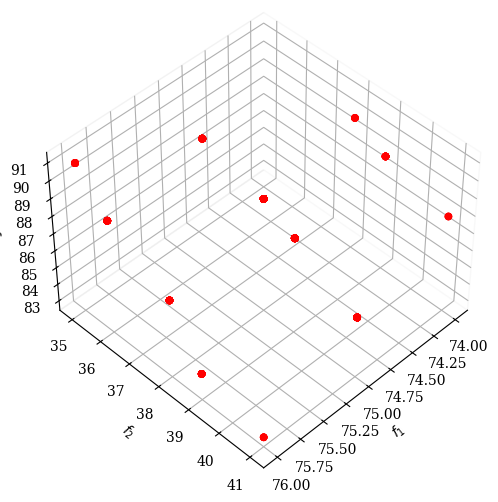

In [60]:
#散点图可视化
from pymoo.visualization.scatter import Scatter
plot = Scatter()
plot.add(-1*res.F, color="red")
plot.show()

In [68]:
#帕累托前沿参数组合
map_X = np.apply_along_axis(map_input, 1, res.X)
print("[bcr,tier,residential,office,amenity,civic]")
print(map_X)

[bcr,tier,residential,office,amenity,civic]
[[0.9 3.  0.1 0.1 0.7 0.1]
 [0.9 3.  0.1 0.2 0.1 0.6]
 [0.9 3.  0.1 0.6 0.1 0.2]
 ...
 [0.9 3.  0.1 0.3 0.3 0.3]
 [0.9 3.  0.1 0.1 0.4 0.4]
 [0.9 3.  0.1 0.3 0.3 0.3]]


In [69]:
#帕累托前沿得分
print(-1*res.F)

[[76. 32. 92.]
 [76. 41. 83.]
 [74. 41. 88.]
 ...
 [75. 38. 89.]
 [76. 36. 89.]
 [75. 38. 89.]]


In [77]:
#打印每一项中得分最大的解
data = -1*res.F
input = map_X
#最高得分
max_score = np.max(data,axis=0)
id_0 = np.where(data[:,0]==max_score[0])
id_1 = np.where(data[:,1]==max_score[1])
id_2 = np.where(data[:,2]==max_score[2])
print(map_X[id_0[0][0]],data[id_0[0][0]])
print(map_X[id_1[0][0]],data[id_1[0][0]])
print(map_X[id_2[0][0]],data[id_2[0][0]])

[0.9 3.  0.1 0.1 0.7 0.1] [76. 32. 92.]
[0.9 3.  0.1 0.2 0.1 0.6] [76. 41. 83.]
[0.9 3.  0.1 0.1 0.7 0.1] [76. 32. 92.]


In [65]:
# 求最优解中总分最大的解
data = -1*res.F
input = map_X
id = np.where(data==[76,35,90])
# id = np.where(np.sum(data,axis=1)==np.max(np.sum(data,axis=1)))
print("参数:",np.unique(input[id[0]],axis=0),"最高分:",np.unique(data[id[0]],axis=0),"总分:",np.unique(np.sum(data[id[0]],axis=1)))

参数: [[0.9 3.  0.1 0.1 0.2 0.6]
 [0.9 3.  0.1 0.1 0.3 0.5]
 [0.9 3.  0.1 0.1 0.4 0.4]
 [0.9 3.  0.1 0.1 0.5 0.3]
 [0.9 3.  0.1 0.2 0.1 0.6]
 [0.9 3.  0.1 0.2 0.4 0.3]
 [0.9 3.  0.1 0.3 0.3 0.3]
 [0.9 3.  0.1 0.3 0.4 0.2]
 [0.9 3.  0.1 0.4 0.1 0.4]
 [0.9 3.  0.1 0.4 0.2 0.3]
 [0.9 3.  0.1 0.5 0.2 0.2]
 [0.9 3.  0.1 0.5 0.3 0.1]] 最高分: [[74. 38. 90.]
 [75. 36. 90.]
 [76. 32. 92.]
 [76. 35. 91.]
 [76. 36. 89.]
 [76. 38. 87.]
 [76. 39. 84.]
 [76. 41. 83.]] 总分: [199. 200. 201. 202.]
